In [1]:
import sys
import os

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


2022-05-13 07:51:01.486461: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 07:51:01.486508: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
#import t=privachy version 
import tensorflow_privacy

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy


### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***


***NOTE JIM: had to make batch_size 25 so DP optimizer would run with same hyperparams

In [4]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=1000,
                           n_classes=n_classes, 
                           n_features=300,
                           n_informative=300,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]




In [5]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

### Define the target model architecture

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [6]:
# Define target model
# Tensorflow model (MLP) (making it big to make it overfit)

input_data = Input(shape = Xt_member[0].shape)
x = Dense(128, activation='relu')(input_data)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
output = Dense(2, activation='softmax')(x)

2022-05-13 07:51:04.885981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-13 07:51:04.886032: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-13 07:51:04.886071: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-05-13 07:51:04.886365: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Now try the SafeKerasModel version

In [7]:
import importlib
import safemodel
from safemodel.classifiers.safekeras import Safe_KerasModel



importlib.reload(safemodel.safemodel)
importlib.reload(safemodel.classifiers.safekeras)
from safemodel.classifiers.safekeras import Safe_KerasModel



In [8]:
optimizer=None
safeModel = Safe_KerasModel(inputs= input_data, outputs=output,name="safekeras-test")


args is a <class 'tuple'> = ()  kwargs is a <class 'dict'>= {'inputs': <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>, 'outputs': <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>, 'name': 'safekeras-test'}
- parameter optimizer = None identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.Nothing currently implemented to change type of parameter optimizer from NoneType to tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.



In [9]:
#safeModel.__dict__


In [10]:
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)


safeModel.compile(loss=loss)#optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [11]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_optimizer_is_DP(safeModel.optimizer)
print(f' It is {dpused} that the moddel will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the moddel will be DP because optimiser does  contain key _was_dp_gradients_called so should be DP.


(250, 300)
DP-SGD with sampling rate = 10% and noise_multiplier = 0.5 iterated over 200 steps satisfies differential privacy with eps = 50.3 and delta = 1e-05.
The optimal RDP order is 1.5.
Current epsilon is 50.301726361197794
this is not going to be ok do you want to continue [Y/N]Y
Continuing
Epoch 1/20
10/10 [==============================] - 3s 72ms/step - loss: 2.1417 - accuracy: 0.5200 - val_loss: 2.1952 - val_accuracy: 0.5400
Epoch 2/20
10/10 [==============================] - 0s 33ms/step - loss: 1.7855 - accuracy: 0.5600 - val_loss: 1.9715 - val_accuracy: 0.5560
Epoch 3/20
10/10 [==============================] - 0s 35ms/step - loss: 1.4388 - accuracy: 0.6080 - val_loss: 1.9656 - val_accuracy: 0.5600
Epoch 4/20
10/10 [==============================] - 0s 34ms/step - loss: 1.1908 - accuracy: 0.6400 - val_loss: 1.9045 - val_accuracy: 0.5520
Epoch 5/20
10/10 [==============================] - 0s 40ms/step - loss: 1.0705 - accuracy: 0.6840 - val_loss: 1.8999 - val_accuracy: 0.552

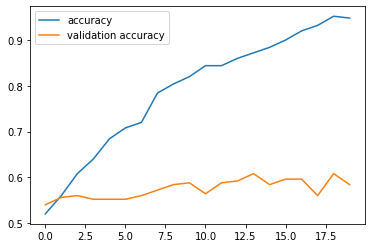

In [12]:
epochs = 20
batch_size = 25

r_DP = safeModel.fit(Xt_member, 
              yt_member, 
              validation_data=(Xt_nonmember, yt_nonmember),
              epochs=epochs, 
              batch_size=batch_size
)  


plt.plot(r_DP.history['accuracy'], label='accuracy')
plt.plot(r_DP.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show() 


In [13]:
theType= type(safeModel.optimizer)
print(f'optimiser is type {theType}')

dpused,reason = safeModel.check_DP_used(safeModel.optimizer)
print(f' It is {dpused} that the model will be DP because {reason}')

optimiser is type <class 'tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass'>
 It is True that the model will be DP because  value of optimizer._was_dp_gradients_called is True so DP variant of optimiser has been run


## compute privacy

In [14]:
print(f'dataset has {Xt.shape[0]} entries so batch size is {100*safeModel.batch_size/Xt.shape[0]}%')
privacy = compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=Xt.shape[0],
                                              batch_size=safeModel.batch_size,
                                              noise_multiplier=safeModel.noise_multiplier,
                                              epochs=25,#epochs,
                                              delta=1e-5)
print(f'with these settings privacy = {privacy}')

dataset has 500 entries so batch size is 5.0%
DP-SGD with sampling rate = 5% and noise_multiplier = 0.5 iterated over 500 steps satisfies differential privacy with eps = 43.9 and delta = 1e-05.
The optimal RDP order is 1.5.
with these settings privacy = (43.85228589564216, 1.5)


In [15]:
safeModel.save('safekeras.sav')

2022-05-13 07:51:45.619547: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: safekeras.sav/assets


In [16]:
safeModel.preliminary_check()

- parameter optimizer = <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fa8642c4bb0> identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.


('WARNING: model parameters may present a disclosure risk:\n- parameter optimizer = <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fa8642c4bb0> identified as different type to recommendation of tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass.',
 True)

In [17]:
#safeModel.request_release('safekeras.pkl') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.sav') # TypeError: cannot pickle '_thread.RLock' object

#safeModel.request_release('safekeras.tf')
safeModel.request_release('safekeras.h5')

TypeError: cannot pickle '_thread.RLock' object

In [18]:
for key,value in safeModel.__dict__.items():
    print(key,value)

_self_setattr_tracking True
_obj_reference_counts_dict ObjectIdentityDictionary({<_ObjectIdentityWrapper wrapping <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'input_1')>>: 1, <_ObjectIdentityWrapper wrapping <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_3')>>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping ListWrapper([])>: 1, <_ObjectIdentityWrapper wrapping 'andy'>: 1, <_ObjectIdentityWrapper wrapping 'KerasModel'>: 1, <_ObjectIdentityWrapper wrapping 10>: 1, <_ObjectIdentityWrapper wrapping 1e-05>: 1, <_ObjectIdentityWrapper wrapping 25>: 1, <_ObjectIdentityWrapper wrapping 1.0>: 1, <_ObjectIdentityWrapper wrapping 0.5>: 1, <_ObjectIdentityWrapper wrapping 0.1>: 1, <_ObjectIdentityWrapper wrapping <tensorflow_privacy.privacy.optimizers.dp_optimizer_keras.make_keras_optimizer_class.<locals>.DPOptimizerClass object at 0x7fa8642c4bb0>>: 1, <_ObjectIdentityWrapper wrapping <keras.engine.compile_utils.L

In [ ]:
# create and fit using recommended params
print("***Test 1: researcher doesn't change recommended params")
safeKerasModel1 = Safe_KerasModel(input_data, output)
safeKerasModel1.compile()
safeKerasModel1.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel1.save(name="safe1.pkl")
safeKerasModel1.preliminary_check()
safeKerasModel1.request_release(filename="safe1.pkl")


# change model params to recommended values
print("\n***Test 2: researcher changes params safely")
safeKerasModel2 = Safe_KerasModel(input_data, output)
safeKerasModel2.compile()
safeKerasModel2.optimizer="DPAdam"
safeKerasModel2.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel2.save(name="safe2.pkl")
safeKerasModel2.preliminary_check()
safeKerasModel2.request_release(filename="safe2.pkl")

# change one model params in an unsafe way
print("\n***Test 3: researcher changes string params unsafely")
safeKerasModel3 = Safe_KerasModel(input_data, output)
safeKerasModel3.compile()
safeKerasModel3.optimizer="Adam"
safeKerasModel3.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel3.save(name="unsafe3.pkl")
safeKerasModel3.preliminary_check()
safeKerasModel3.request_release(filename="unsafe3.pkl")

# change another model params in an  unsafe way


# change another model params in an  unsafe way
print("\n***Test 5: researcher changes string and numeric params unsafely")


In [ ]:
# change another model params in an  unsafe way but tells preliminary_check() not to overwrite params
print("\n***Test 6: researcher changes string and numeric params unsafely")
safeKerasModel6 = Safe_KerasModel(input_data, output)
safeKerasModel6.compile()
safeKerasModel6.optimizer="Adam"
safeKerasModel6.fit(Xt_member, 
                    yt_member, 
                    validation_data=(Xt_nonmember, yt_nonmember),
                    epochs=epochs, 
                    batch_size=batch_size)
safeKerasModel6.save(name="unsafe6.pkl")
safeKerasModel6.preliminary_check(apply_constraints=False)
safeKerasModel6.request_release(filename="unsafe6.pkl")